## 2 [indicateur](#section_2) 
## 3 [prédiction](#section_3) 
## 4 [évaluation](#section_4) 
## 5 [bot](#section_5) 

In [1]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

In [2]:
plus=60
high=0.7
low=0.8


font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# ----- Functions Definition -------
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(14,14))
            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            else  :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            # affichage des flèches
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")         
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',
                                 rotation=label_rotation, color="blue", alpha=0.5)           
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)     
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
    return ci


def getBalance(myclient, coin):
    jsonBalance = myclient.get_balances()
    pandaBalance = pd.DataFrame(jsonBalance)
    if pandaBalance.loc[pandaBalance['coin'] == coin].empty : return 0
    else : return float(pandaBalance.loc[pandaBalance['coin'] == coin]['free'])

def truncate(n, decimals=0):
    r = floor(float(n*0.99)*10**decimals)/10**decimals
    return str(r)


#valeur à prédire

def plus_x_fois_j(data,x=3,j=1):
    from scipy.special import cbrt #racine cubique 3
    data['plus_x']=np.nan
    data['plus_x'][:-x]=data['close'].values[x:]
    data['plus_x']=(data['plus_x']/data['close']-1)*100*j
#    for i, date in enumerate(data[:-x].index) :
#        value=(data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100*j      
#        data.loc[date,'plus_x'] = value.clip(-3,3)
    data['plus_x']=data['plus_x'].clip(-10,10)
    data['plus_x_-x']=0
    data['plus_x_-x'][x:]=data['plus_x'].values[:-x]
    return data

def plus_x_classifier_h_l(data,x=3,high=1,low=1):
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        v=(data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100
        if   v >=  high :
            data.loc[date,'plus_x'] = 3
        elif v <= -low  :
            data.loc[date,'plus_x'] = 1
        else :
            data.loc[date,'plus_x'] = 2
    return data

def plus_x_ou_moins(data,x=3):
    data['plus_x']=np.nan
    for i, date in enumerate(data[:-x].index) :
        v=(data.iloc[i+x]['close']/data.iloc[i]['close']-1)*100
        if   v >=  0 :
            data.loc[date,'plus_x'] = 3
        else :
            data.loc[date,'plus_x'] = 1
    return data

#indicateur
def indicator(data):
    x=60
    window_h=14*x
    #data['VarianceHigh']  = (data['high']-data['close'])
    #data['VarianceLow']   = (data['close']-data['low'])
    data['RollingMax']    = data['close']-data['close'].shift(1).rolling(window=x).max()
    data['RollingMin']    = data['close'].shift(1).rolling(window=x).min()-data['close']
    #data['SMA']=ta.trend.sma_indicator(data['close'], window=12)

    #Exponential Moving Average
    data['SMA50-150']= ta.trend.sma_indicator(data['close'],50)-ta.trend.sma_indicator(data['close'], 150)
    data['SMAx-x*3'] = ta.trend.sma_indicator(data['close'],window_h)-ta.trend.sma_indicator(data['close'], window_h*3)

    # #MACD
#    MACD = ta.trend.MACD(close=data['close'], window_fast=12, window_slow=26, window_sign=9)
#    data['MACD'] = MACD.macd()
#    data['MACD_SIGNAL'] = MACD.macd_signal()
#    data['MACD_DIFF'] = MACD.macd_diff() #Histogramme MACD
    
    # #Awesome Oscillator
    data['AWESOME_OSCILLATOR'] = ta.momentum.awesome_oscillator(high=data['high'], low=data['low'], window1=5, window2=34)

    # # Kaufman’s Adaptive Moving Average (KAMA)
    #data['KAMA'] = ta.momentum.kama(close=data['close'], window=10, pow1=2, pow2=30)

    #Relative Strength Index (RSI)
#    data['RSI'] =ta.momentum.rsi(close=data['close'], window=window_h)

    # #Stochastic RSI
    data['STOCH_RSI'] = ta.momentum.stochrsi(close=data['close'], window=window_h, smooth1=3, smooth2=3) #Non moyenné 
    #data['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=data['close'], window=window_h, smooth1=3, smooth2=3) #Orange TradingView
    #data['STOCH_RSI_K'] =ta.momentum.stochrsi_k(close=data['close'], window=window_h, smooth1=3, smooth2=3) #Bleu sur TradingView
   
    # -- Trix Indicator -- sell and buy
    trixLength = 9*x
    trixSignal = 21*x
    data['TRIX_PCT'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=data['close'],
                                            window=trixLength), window=trixLength), window=trixLength).pct_change()*100
    data['TRIX_HISTO'] = (data['TRIX_PCT'] - ta.trend.sma_indicator(data['TRIX_PCT'],trixSignal))*100
    #data.loc[:,'buy_TRIX+0_STOCH_RSI-0.8']=0
    #data.loc[(data['TRIX_HISTO']>0) & (data['STOCH_RSI']<0.8),'buy_TRIX+0_STOCH_RSI-0.8']=1
    data.loc[:,'buy_TRIX+0_STOCH_RSI-0.7']=data['TRIX_HISTO']*(data['STOCH_RSI']-0.7)
    data.loc[:,'buy_TRIX+0_STOCH_RSI-0.5']=data['TRIX_HISTO']*(data['STOCH_RSI']-0.5)
    #data.loc[:,'sell_TRIX-0_STOCH_RSI+0.2_0_1']=0
    #data.loc[(data['TRIX_HISTO']<0) & (data['STOCH_RSI']>0.2),'sell_TRIX-0_STOCH_RSI+0.2_0_1']=-data.loc[:,'buy_TRIX+0_STOCH_RSI-0.8']
    data.loc[:,'sell_TRIX-0_STOCH_RSI+0.2']=-data['TRIX_HISTO']*(0.2-data['STOCH_RSI'])
    data.loc[:,'buy_TRIX+0_STOCH_RSI']=data['TRIX_HISTO']+(data['STOCH_RSI'])
    
    # #Average True Range (ATR) trop de NAN
    data['ATR'] = ta.volatility.average_true_range(high=data['high'], low=data['low'], close=data['close'], window=window_h)


    # #Choppiness index
    data['CHOP'] = get_chop(high=data['high'], low=data['low'], close=data['close'], window=window_h)  
    
        # #Super Trend
    #ST_length = 10
    #ST_multiplier = 3.0
    #superTrend = pda.supertrend(high=data['high'], low=data['low'], close=data['close'], length=ST_length,
    #                            multiplier=ST_multiplier)
    #data['SUPER_TREND'] = superTrend['SUPERT_'+str(ST_length)+"_"+str(ST_multiplier)] #Valeur de la super trend

    
    return data

def evaluation(data_t,best,X_test,Y_test,limit_lose=0):
    frais=0.00067
    btc=0.0
    usdt=100
    lastindex=data_t.first_valid_index()
    last_achat=0
    nbr_achat=0
    nbr_vends=0
    
    for index,row in data_t.iterrows():
        if  data_t['buy'][index] and usdt>10:
            btc =usdt/data_t['close'][index]
            btc = btc - (frais*btc)
            usdt=0
            last_achat=data_t['close'][index]
            nbr_achat+=1
            #print(f"{btc:.0f} btc                                         ",index)

        if  (data_t['sell'][index] or data_t['close'][index]<limit_lose*last_achat) and btc > 0.0001:
            usdt =btc*data_t['close'][index]
            usdt = usdt -(0.007*usdt)
            btc=0
            nbr_vends+=1
            #print(f"                      {usdt:.0f} $                     ",index)
        lastindex=index
        
    resultat=usdt +btc*data_t['close'].iloc[-1]
    #plot_confusion_matrix(best, X_test, Y_test,cmap='cool') 
    #plot_confusion_matrix(best, X_test, Y_test,normalize='true',cmap='spring')
    plt.show()
    print(f"nbr achat : {nbr_achat}     nbr vends : {nbr_vends}")
    print(f"resultat = {resultat:.0f} $    score train = {best.score(X_train, Y_train):.2f}",
          f"   score valid  : {best.score(X_valid, Y_valid):.2f}  score test  : {best.score(X_test, Y_test):.2f}")
    
    return resultat


# <a class="anchor" id="section_2"></a> indicateur

In [3]:
#gestion des dichiers
import os
from pathlib import Path
import pickle
import wget 

if not Path( r'./Data/btcusdt_train_minute.pkl').is_file() :
    print('dl le fichier dans data en cours: ')
    os.makedirs('./Data/', exist_ok=True)
    client = Client()
    klinesT = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "01 january 2012")
    df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    df['close'] = pd.to_numeric(df['close'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['open'] = pd.to_numeric(df['open'])
    df = df.set_index(df['timestamp'])
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.drop( ['timestamp','open',
                   'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'],axis=1)
    df.to_pickle(r'./Data/btcusdt_train_minute.pkl')
else:
    df= pd.read_pickle(r'./Data/btcusdt_train_minute.pkl')
    
df=df[-int(7e4):]

 
df=plus_x_fois_j(df,30,1)
#df=plus_x_classifier_h_l(df,plus,high,low)
df=indicator(df)    
df.describe()

<ipython-input-2-8b17e515272a>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['plus_x'][:-x]=data['close'].values[x:]
<ipython-input-2-8b17e515272a>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['plus_x_-x'][x:]=data['plus_x'].values[:-x]


,high,low,close,plus_x,plus_x_-x,RollingMax,RollingMin,SMA50-150,SMAx-x*3,AWESOME_OSCILLATOR,STOCH_RSI,TRIX_PCT,TRIX_HISTO,buy_TRIX+0_STOCH_RSI-0.7,buy_TRIX+0_STOCH_RSI-0.5,sell_TRIX-0_STOCH_RSI+0.2,buy_TRIX+0_STOCH_RSI,ATR,CHOP
count,70000.000000,70000.000000,70000.000000,69970.000000,70000.000000,69940.000000,69940.000000,69851.000000,67481.000000,69967.000000,68322.000000,68382.000000,67123.000000,67123.000000,67123.000000,67123.000000,67123.000000,70000.000000,69160.000000
mean,53184.336727,53122.885955,53153.857074,0.014663,0.014657,-225.574993,-250.750354,11.730592,177.422481,3.409382,0.508583,0.000410,-0.001364,0.016279,0.016007,0.015597,0.508225,60.656937,48.135715
std,7701.442559,7696.762304,7699.596665,0.507633,0.507524,232.348009,275.405372,223.210352,877.503240,138.711397,0.281721,0.002285,0.173372,0.054475,0.043433,0.069090,0.376697,14.880887,4.275859
min,40029.890000,39600.000000,39681.000000,-5.976385,-5.976385,-3292.380000,-3865.290000,-1252.857533,-2251.338377,-1687.657235,0.000000,-0.006849,-0.584236,-0.273732,-0.195523,-0.282294,-0.448800,0.000000,33.372109
25%,46803.882500,46745.957500,46777.302500,-0.234339,-0.234231,-302.392500,-330.987500,-95.434900,-290.312968,-64.861588,0.261363,-0.000769,-0.113759,-0.009136,-0.007264,-0.019520,0.195200,52.316292,45.234046
50%,54612.870000,54548.035000,54578.660000,0.000715,0.000474,-171.930000,-181.390000,2.811800,181.780933,0.459500,0.520483,0.000280,-0.012981,0.007380,0.008095,0.001224,0.492703,60.906304,48.353913
75%,60989.405000,60935.282500,60964.310000,0.250042,0.249922,-80.000000,-81.650000,104.840433,740.930500,67.717103,0.753403,0.001914,0.113218,0.036331,0.036971,0.041155,0.841456,69.617587,51.469984
max,67000.000000,66901.010000,66930.010000,6.067519,6.067519,1336.140000,1925.530000,1578.860800,2680.428762,1725.065765,1.000000,0.008302,0.513178,0.314160,0.224400,0.332218,1.415272,103.404044,61.810366


(67093, 19)


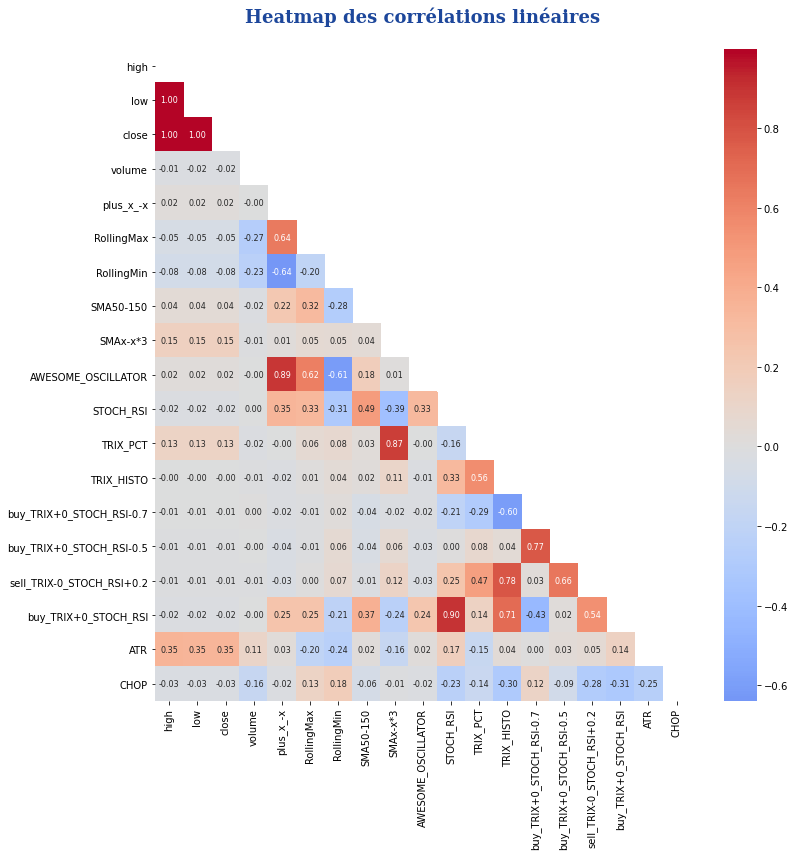

In [4]:
df=df.dropna(axis=0)
data_save=df
plus_x=df['plus_x']
data_t=df.drop('plus_x',axis=1).copy()
print(data_t.shape)
preprocessor=StandardScaler().fit(data_t)
    
data_t  = preprocessor.transform(data_t)
data_t = pd.DataFrame(index=df.dropna(axis=0).index,columns= df.drop('plus_x',axis=1).columns,data=data_t)


data_t['sell_TRIX-0_STOCH_RSI+0.2']=data_t['sell_TRIX-0_STOCH_RSI+0.2']*2
data_t['CHOP']=data_t['CHOP']*1

corr = data_t.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", fontdict=font_title);


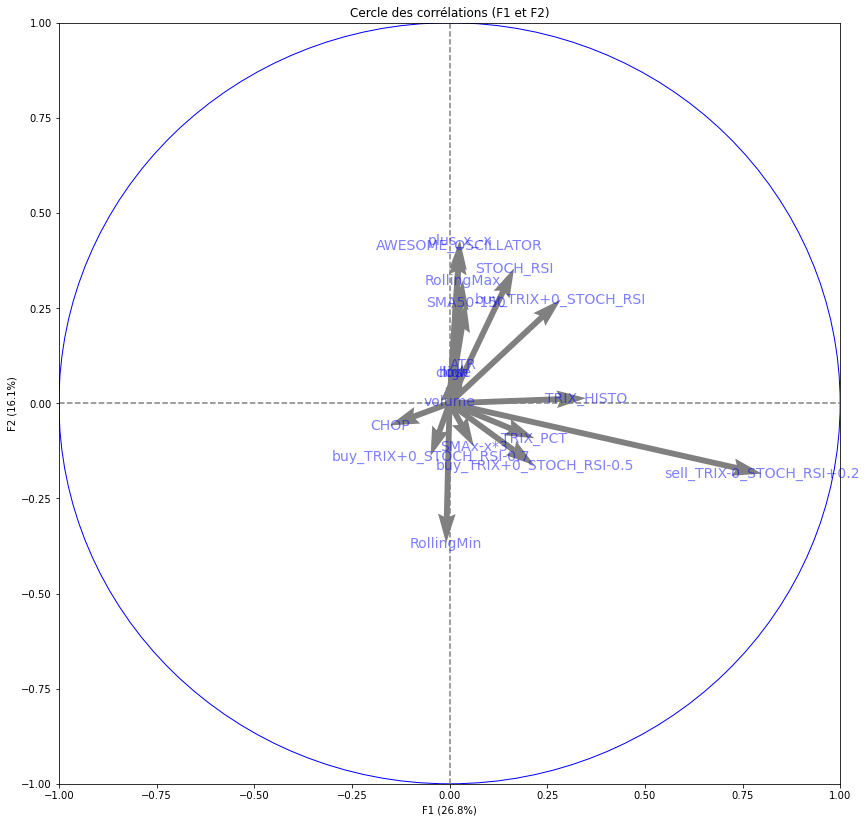

Composante ACP    2.121004e-31
Somme             1.000000e+02
Name: 19, dtype: float64

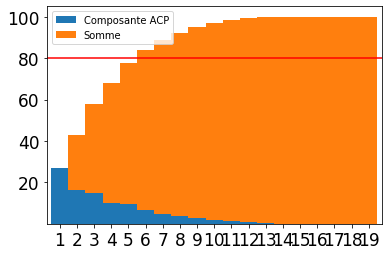

In [5]:
pca = PCA(n_components=len(data_t.columns)) #20)#  On paramètre ici pour ne garder que  composantes

# Résultats de l'ACP
data_ACP= pca.fit_transform(data_t)
data_ACP = pd.DataFrame(index=data_t.index,columns= [np.arange(1,1+len(pca.components_)).astype(str)],data=data_ACP)

display_circles(pca.components_, 3, pca, [(0,1),(2,3),(4,5)], labels =data_t.columns)


Yacp = list(pca.explained_variance_ratio_*100)
Xacp = range(1,len(Yacp)+1)
ycum = np.cumsum(Yacp)

d=pd.DataFrame(index=Xacp,columns= ['Composante ACP','Somme'] )
d['Composante ACP']=Yacp
d['Somme']=ycum-Yacp


d.plot(kind='bar',stacked=True,width=1,figsize=(6,4))
plt.axhline(y=80,color="r")
#plt.xlabel("Composante de l'ACP")
#plt.ylabel('variabilité')
plt.xticks(rotation=0,size=17)
plt.yticks(size=17);
#plt.title('ACP par compossante');
d.iloc[-1,:]

preprocessor=StandardScaler().fit(data_sortie)
data_sortie=preprocessor.transform(data_sortie)
data_sortie = pd.DataFrame(index=data_t.index,columns= [np.arange(1,1+len(pca.components_)).astype(str)],data=data_sortie)

# <a class="anchor" id="section_3"></a>prédiction

In [6]:
X = df.drop(['plus_x','low','high'],axis=1).copy() # data_ACP #
Y = np.array(plus_x).reshape(-1, 1)
    
#X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
multi=3
X_train1 = X[:-3600*multi]
Y_train1 = Y[:-3600*multi]
X_test   = X[-3600*multi:]
Y_test   = Y[-3600*multi:]
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=13)



# <a class="anchor" id="section_4"></a> évaluation
## ghg

test (10800, 23)
nbr achat : 10     nbr vends : 9
resultat = 91 $    score train = 0.99    score valid  : 0.94  score test  : -0.27


91.10601740879875

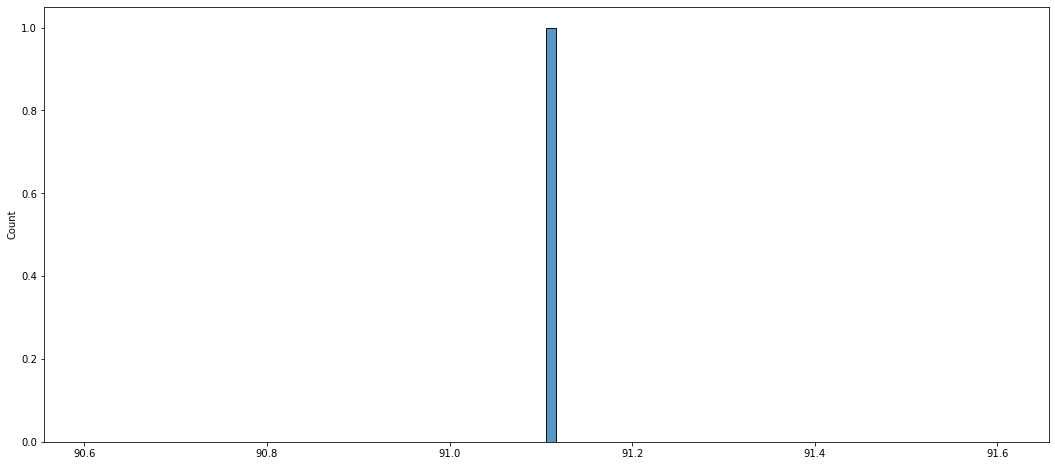

In [7]:
import warnings
warnings.filterwarnings('ignore')

resultat=[]  
  


for i in range(0,1):    



    best = RandomForestRegressor(n_jobs=-2,n_estimators=200,random_state=0).fit(X_train, Y_train)
  
   
    df['predict']=best.predict(X)

    df.loc[:,'buy' ] = 0
    df.loc[:,'sell'] = 0
    df.loc[df['predict'] >= 0.4,'buy' ] = 1
    df.loc[df['predict'] <= -0.4,'sell'] = 1    
    data_r=df.loc[X_test.index.values,:].copy()
    print(f"test {data_r.shape}")
    resultat.append(evaluation(data_r,best,X_test,Y_test,0.90))
    
fig = plt.figure(figsize=(18, 8))
sns.histplot(resultat, bins=100)
#plt.xscale('log');
np.array(resultat).mean()

0.9901989346198933

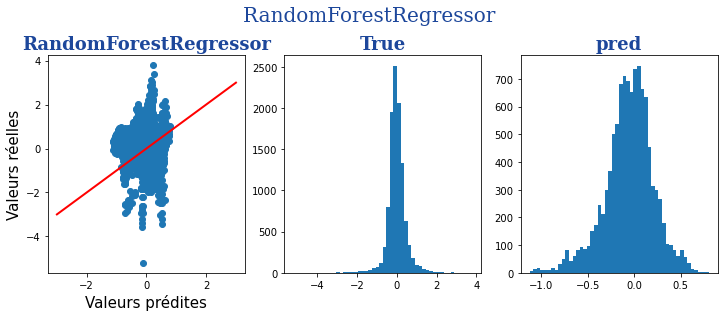

In [8]:
import pylab
fig = plt.figure(figsize=(12, 4))
plt.suptitle(f"RandomForestRegressor \n", fontdict=font_title,fontsize=20, y=1.05)

plt.subplot(1,3,1)
plt.plot([-3, 3], [-3, 3], 'r', lw=2) # Red straight line
pylab.scatter(best.predict(X_test),Y_test)
plt.ylabel("Valeurs réelles",fontsize=15) 
plt.xlabel("Valeurs prédites" ,fontsize=15)
plt.title("RandomForestRegressor", fontdict=font_title)

plt.subplot(1,3,2)
plt.hist(Y_test,bins=50) 
plt.xlabel(" " ,fontsize=15)
plt.title("True", fontdict=font_title)

plt.subplot(1,3,3)
plt.hist(best.predict(X_test),bins=50) 
plt.xlabel(" " ,fontsize=15)
plt.title("pred", fontdict=font_title)

#print(confusion_matrix(Y_test, best.predict(X_test)))
data_r['close'][-1]/data_r['close'][0]

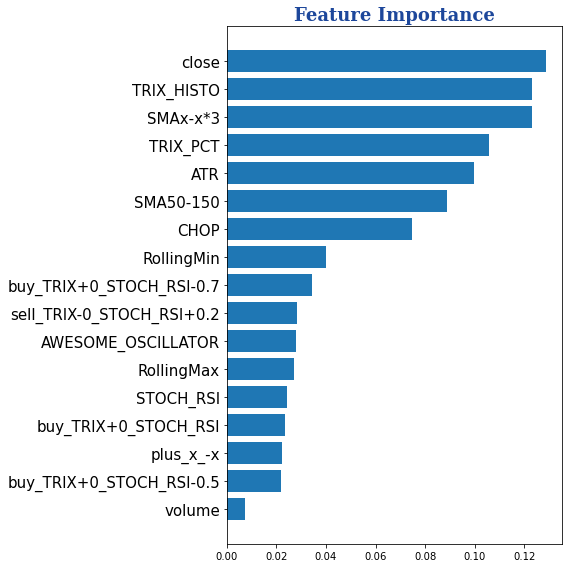

In [9]:
best.fit(X_test,Y_test)
# Get Feature importance data using feature_importances_ attribute
feature_importance = best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx],size=15)

plt.title('Feature Importance',fontdict=font_title)

fig.tight_layout()
plt.show()

from sklearn.model_selection import learning_curve

N,train_score,val_score=learning_curve(best, X_train,Y_train,train_sizes=np.linspace(0.2,1,5))


plt.plot(N,val_score.mean(axis=1),'g',label='validation')
plt.plot(N,train_score.mean(axis=1),label='train');
plt.ylabel("pourcentages d'apprentissage",fontsize=15) 
plt.xlabel("train_sizes" ,fontsize=15)  
plt.title("learning_curve", fontdict=font_title)
plt.legend();

In [10]:
import math
from scipy.special import cbrt
cbrt(math.ceil(0.99-1))

0.0

In [11]:

df

,high,low,close,volume,plus_x,plus_x_-x,RollingMax,RollingMin,SMA50-150,SMAx-x*3,...,TRIX_HISTO,buy_TRIX+0_STOCH_RSI-0.7,buy_TRIX+0_STOCH_RSI-0.5,sell_TRIX-0_STOCH_RSI+0.2,buy_TRIX+0_STOCH_RSI,ATR,CHOP,predict,buy,sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-15 23:43:00,48088.82,48068.43,48068.44,24.41123000,0.155341,-0.600860,-360.97,-2.12,74.909067,875.065635,...,0.022377,-0.012523,-0.008048,-0.001334,0.162745,40.931819,47.404772,0.139482,0,0
2021-09-15 23:44:00,48068.44,48055.00,48055.00,23.11962000,0.256581,-0.673326,-374.41,11.32,71.500533,875.052083,...,0.022243,-0.012827,-0.008378,-0.001705,0.145574,40.899090,47.401364,0.197270,0,0
2021-09-15 23:45:00,48131.47,48052.00,48106.63,65.51209000,0.107802,-0.566774,-322.78,-51.63,68.747867,875.055611,...,0.022108,-0.011401,-0.006979,-0.000347,0.206412,40.945008,47.418755,0.066564,0,0
2021-09-15 23:46:00,48110.00,48072.42,48082.73,14.34541000,0.027765,-0.655742,-346.68,-27.73,65.618333,875.050476,...,0.021971,-0.011996,-0.007602,-0.001011,0.175978,40.941002,47.426125,0.041456,0,0
2021-09-15 23:47:00,48087.31,48064.82,48076.86,20.76081000,0.061922,-0.637323,-352.55,-21.86,62.056733,874.998734,...,0.021834,-0.012083,-0.007717,-0.001167,0.168403,40.919037,47.417222,0.073971,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01 15:51:00,61500.00,61451.56,61482.02,13.59389000,-0.006571,-0.050818,-124.86,-161.96,-184.185733,173.135774,...,0.158121,-0.024131,0.007494,0.054930,0.705512,68.648729,45.628895,0.060292,0,0
2021-11-01 15:52:00,61482.01,61451.57,61458.54,8.59030000,0.031696,-0.133635,-134.67,-138.48,-183.824400,173.306802,...,0.157681,-0.025414,0.006122,0.053427,0.696508,68.603254,45.624416,0.071215,0,0
2021-11-01 15:53:00,61458.53,61420.02,61445.58,11.49314000,-0.023745,-0.177760,-120.30,-125.52,-182.120467,173.442433,...,0.157239,-0.026086,0.005362,0.052533,0.691338,68.567441,45.620075,0.071373,0,0
